In [154]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

import subprocess
import os
import shutil
import json
from pathlib import Path
import pathlib

from sklearn.manifold import TSNE

import pandas as pd
from optuna.visualization import plot_pareto_front
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

# Load and predict

## Load the data

In [155]:
data_path = Path("/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/imputation/chuncks")
test_data = list(data_path.glob("test_*.csv"))
len(test_data)

15

## Load the model

In [156]:
experiment_path = Path("/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14")
best_model_path = experiment_path / "checkpoints" / "model_best.pth"

# Load configuration of the best model
configurations = (experiment_path / "configuration.json")
with open(configurations) as f:
    config_dict = json.load(f)

test_configurations = "/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/configs/config_test.json"
with open(test_configurations) as f:
    test_config_dict = json.load(f)

keys_to_overwrite = ["test_only", "data_dir", "data_class"]
for key in keys_to_overwrite:
    config_dict[key] = test_config_dict[key]

config_dict["load_model"] = best_model_path

need_root_dir = ["save_dir", "output_dir", "tensorboard_dir"]
for key in need_root_dir:
    config_dict[key] = Path("/Users/oliver/TU_BERLIN/MASTER") / config_dict[key]


# Save the updated config_dict to a JSON file
updated_config_path = experiment_path / "prediction_config.json"
# Convert pathlib path objects to strings
for key, value in config_dict.items():
    if isinstance(value, pathlib.PosixPath):
        config_dict[key] = str(value)
with open(updated_config_path, "w") as f:
    json.dump(config_dict, f)

with open(test_configurations, "w+") as f:
    json.dump(config_dict, f, indent=4)
    
updated_config_path

PosixPath('/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/prediction_config.json')

## Impute test data with the model

In [157]:
# Get the root directory of the project
root_dir = Path(os.getcwd()).parent
print(root_dir)

# Set the working directory to the root directory of the project
os.chdir(root_dir)


# Define the command to run the Python file
command = ["python", f"{root_dir}/src/main.py", "--config", str(updated_config_path)]
print(command)
# Run the command
subprocess.run(command)

os.chdir(root_dir/"analysis_pipeline")

/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_
['python', '/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/src/main.py', '--config', '/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/prediction_config.json']


2024-07-19 15:35:10,025 | INFO : Reading configuration ...
2024-07-19 15:35:10,026 | INFO : Reading configuration ...
2024-07-19 15:35:10,038 | INFO : Stored configuration file in '/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-19_15-35-10'
2024-07-19 15:35:10,039 | INFO : Running:
/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/src/main.py --config /Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/prediction_config.json

2024-07-19 15:35:10,039 | INFO : Using device: cpu
/Users/oliver/miniconda3/envs/mvts/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better in

2024-07-19 15:35:10,039 | INFO : Running:
/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/src/main.py --config /Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/prediction_config.json

2024-07-19 15:35:10,039 | INFO : Using device: cpu
Loaded model from /Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/checkpoints/model_best.pth. Epoch: 10
2024-07-19 15:35:10,824 | INFO : Evaluating on test set ...


2024-07-19 15:35:10,824 | INFO : Evaluating on test set ...


Evaluating   0.0% | batch:         0 of         1	|	loss: 0.380044	|	snr: -14.6617	|	correlation: 0.793719


In [158]:

test_dir = sorted(list(experiment_path.glob("experiment_*")))[-1]
# Remove all other TEST_directories within the directory except the last one
for directory in experiment_path.glob("experiment_*"):
    if directory != test_dir:
        shutil.rmtree(directory)


# per_batch_test_data = np.load(test_dir / "per_batch_test.npy", allow_pickle=True)
per_batch_test_loaded = torch.load(test_dir / "per_batch_test.pt")
per_batch_test_loaded.keys()

dict_keys(['target_masks', 'targets', 'predictions', 'metrics', 'IDs', 'embeddings'])

# Analysis

In [159]:
per_batch_test_loaded.keys()

dict_keys(['target_masks', 'targets', 'predictions', 'metrics', 'IDs', 'embeddings'])

In [160]:
def plot_channels(matrix, from_channel=0, to_channel=5):
    # Extract the first 5 channels from the matrix
    channels = matrix[:, from_channel:to_channel]
    number_of_channels = to_channel - from_channel
    # Plot the channels
    fig, axs = plt.subplots(number_of_channels, 1, figsize=(10, 10))
    for i in range(number_of_channels):
        axs[i].plot(channels[:, i])
        axs[i].set_ylabel(f'Channel {i+1} Values')

    # Set the plot title and labels
    fig.suptitle('Visualization of First 5 Channels of Multivariate Time Series Data')
    axs[-1].set_xlabel('Time')

    # Display the plot
    plt.show()

In [161]:
SUBJECT_ID = 3

In [162]:
np.array(per_batch_test_loaded["predictions"]).shape

(1, 4, 1700, 428)

In [163]:
SUBJECT_PREDICTION = per_batch_test_loaded["predictions"][0][SUBJECT_ID]
SUBJECT_TARGET = per_batch_test_loaded["targets"][0][SUBJECT_ID]
SUBJECT_EMBEDDING = per_batch_test_loaded["embeddings"][0][SUBJECT_ID]
SUBJECT_MASKS = per_batch_test_loaded["target_masks"][0][SUBJECT_ID]

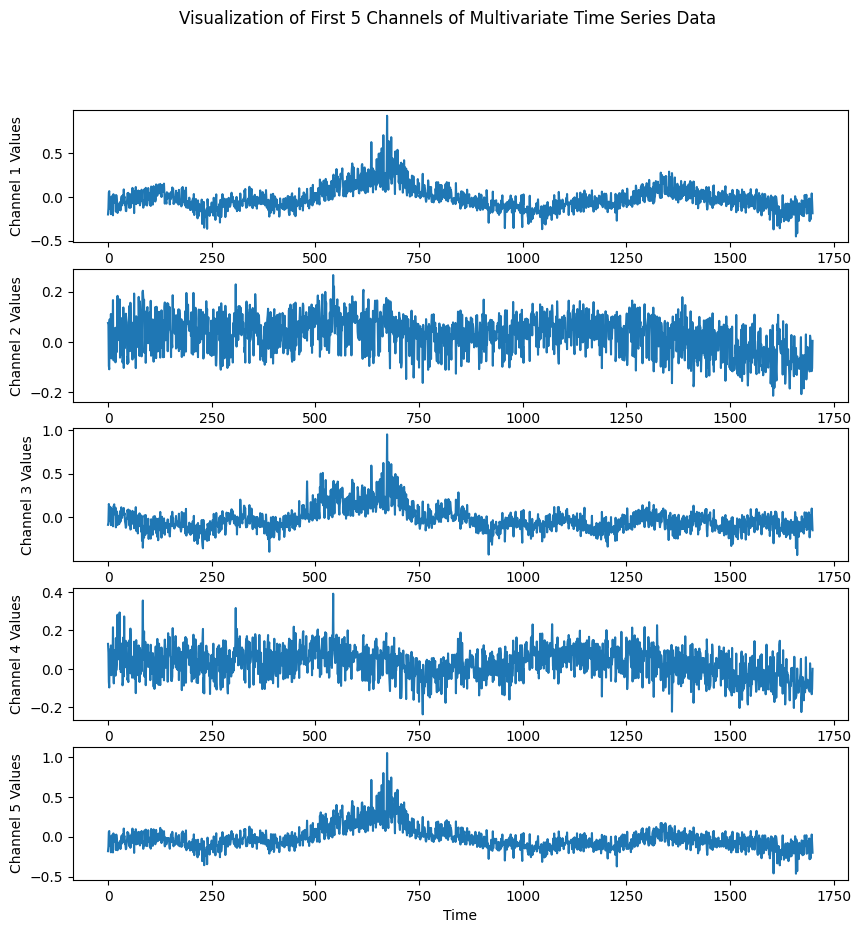

In [164]:
plot_channels(SUBJECT_TARGET, from_channel=0, to_channel=5)

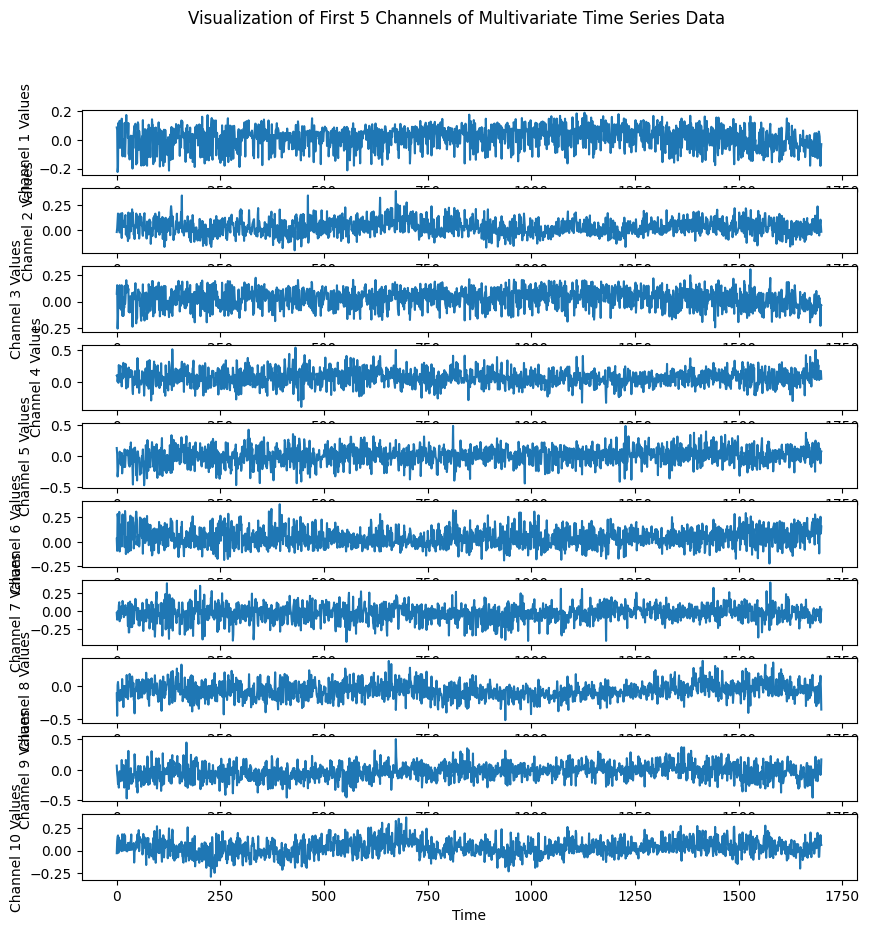

In [165]:
plot_channels(SUBJECT_PREDICTION, from_channel=5, to_channel=15)

In [166]:
def plot_predicted_time_series(true_series, predicted_series):
    # Create a time axis
    time = np.arange(len(true_series))

    # Plot the true time series
    plt.plot(time, true_series, label='True')

    # Plot the predicted time series
    plt.plot(time, predicted_series, label='Predicted')

    # Set the plot title and labels
    plt.title('True vs Predicted Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()

In [167]:
y_true = per_batch_test_loaded["targets"][0][0][:, 0]
y_pred = per_batch_test_loaded["predictions"][0][0][:, 0]

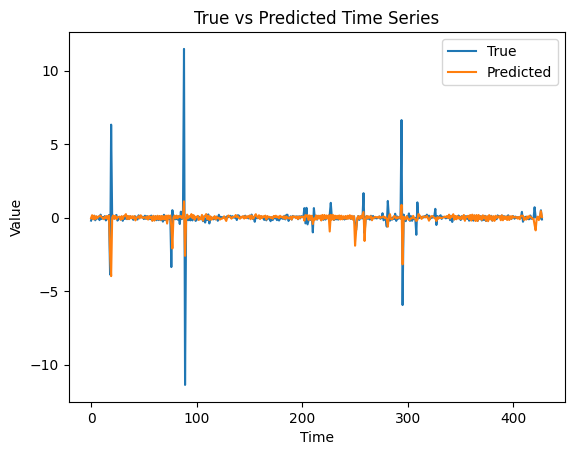

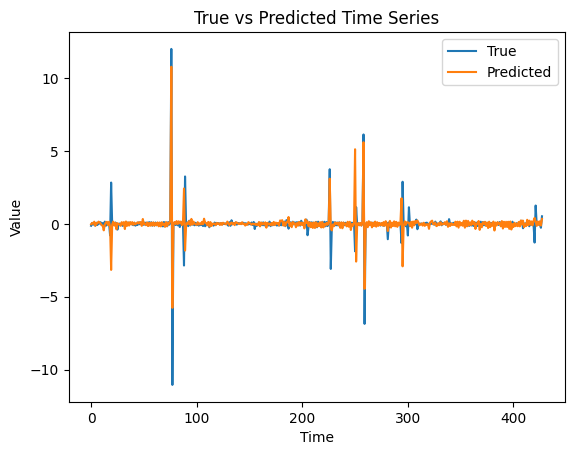

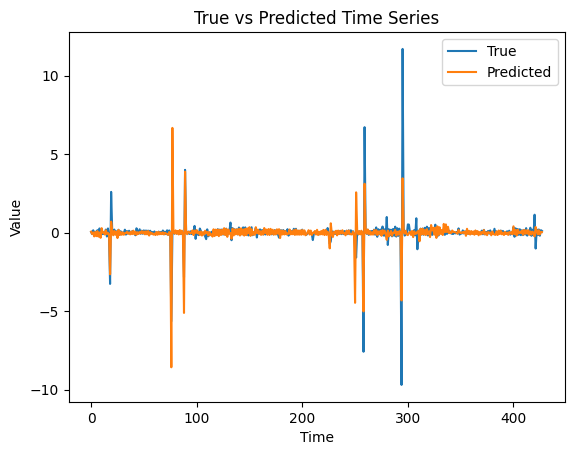

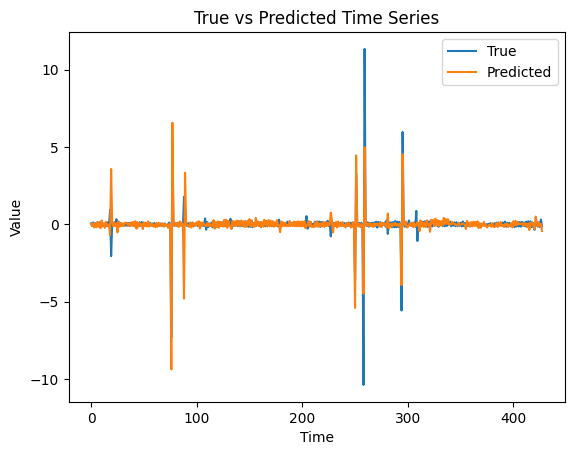

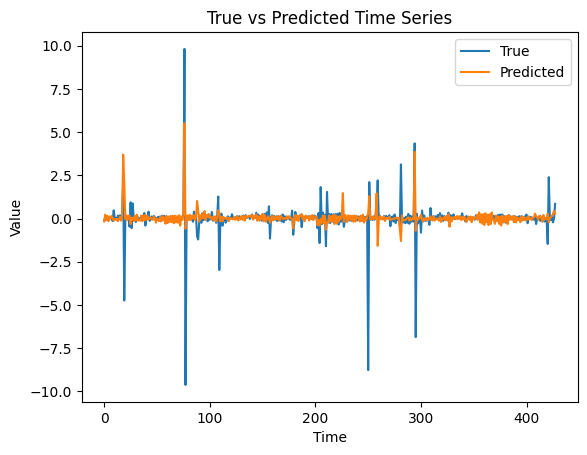

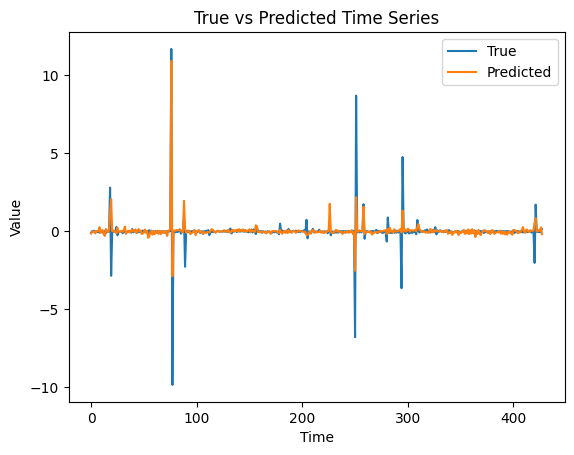

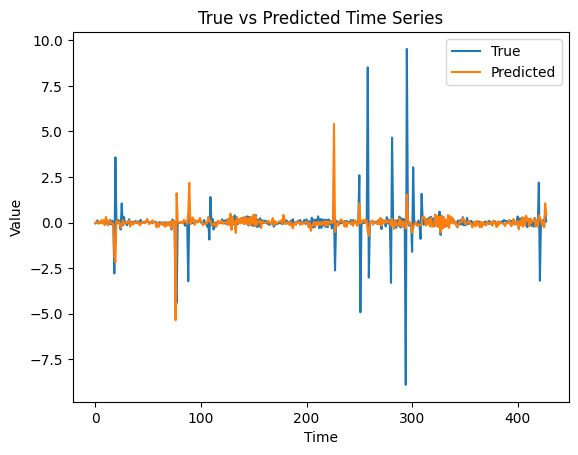

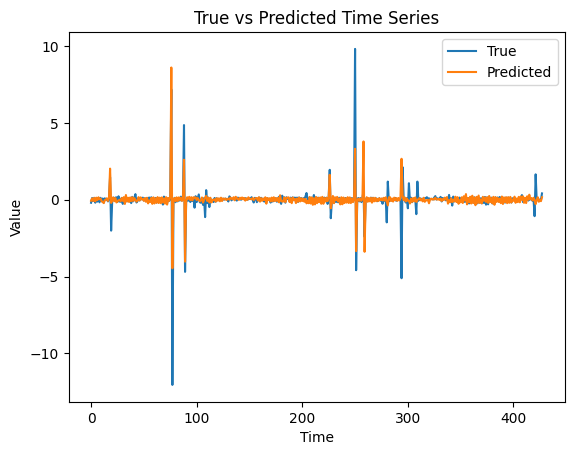

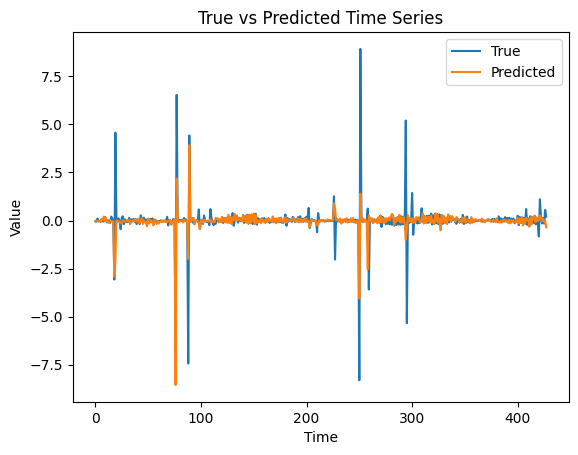

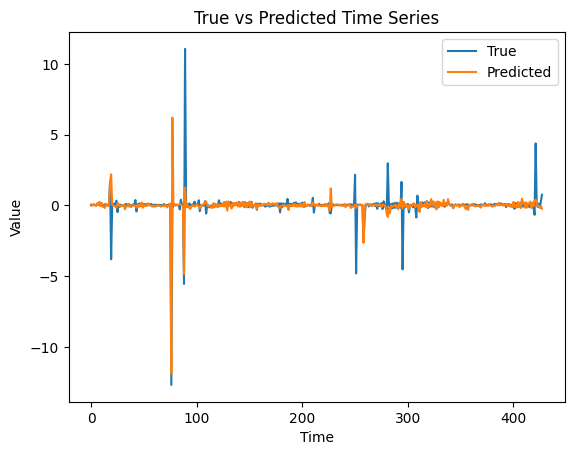

In [186]:
for i in range(10):
    
    plot_predicted_time_series(SUBJECT_TARGET[i], SUBJECT_PREDICTION[i])



In [169]:
def plot_time_series(y_pred, y_true, mask=None):
    # Create a time axis
    time = np.arange(len(y_pred))

    # Plot the predicted values
    plt.plot(time, y_pred, label='Predicted')

    # Plot the true values
    plt.plot(time, y_true, label='True')

    # Highlight the masked areas
    if mask is not None:
        masked_indices = np.where(mask)[0]
        plt.fill_between(time, np.min([y_pred, y_true]), np.max([y_pred, y_true]), where=mask, color='red', alpha=0.3)

    # Set the plot title and labels
    plt.title('Predicted vs True Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()


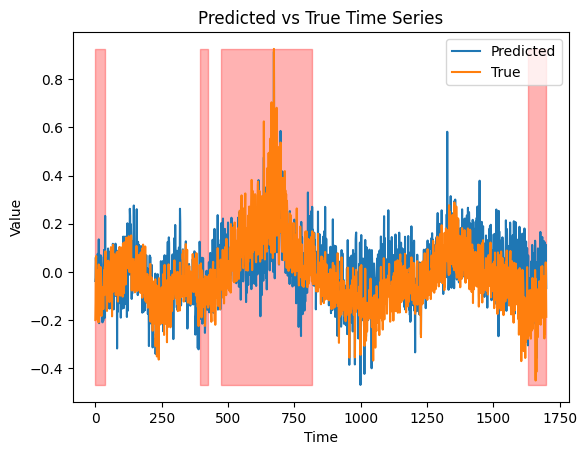

In [189]:
y_true = SUBJECT_TARGET[:, 0]
y_pred = SUBJECT_PREDICTION[:, 0]
y_masked = SUBJECT_MASKS[:, 0]
plot_time_series(y_pred, y_true, y_masked)

In [190]:
def compute_moving_averages(ts, lag):
    ts = np.convolve(ts, np.ones(lag)/lag, mode='valid')
    return ts

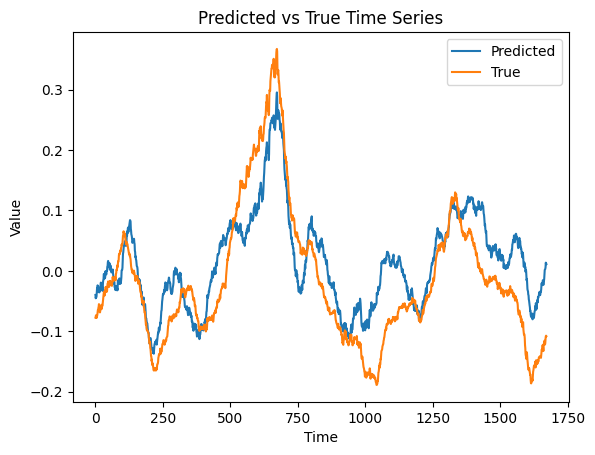

In [191]:
lag = 30
y_true = compute_moving_averages(SUBJECT_TARGET[:, 0], lag)
y_pred = compute_moving_averages(SUBJECT_PREDICTION[:, 0], lag)
plot_time_series(y_pred, y_true)

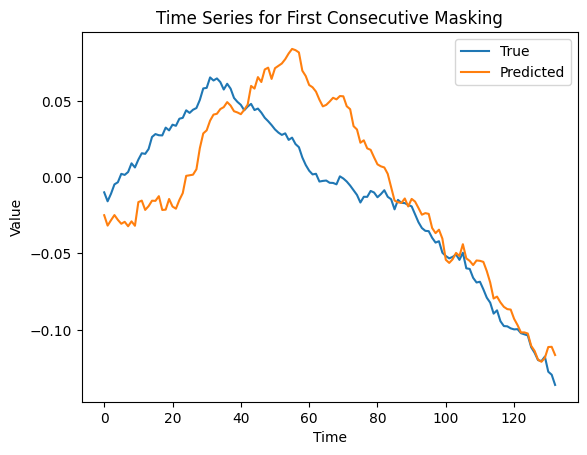

In [192]:

# Find the indices of the first consecutive masking
start_index = 73
end_index = 205

# Extract the masked time series
masked_y_true = y_true[start_index:end_index+1]
masked_y_pred = y_pred[start_index:end_index+1]

# Plot the masked time series
plt.plot(masked_y_true, label='True')
plt.plot(masked_y_pred, label='Predicted')
plt.title('Time Series for First Consecutive Masking')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Learning curve

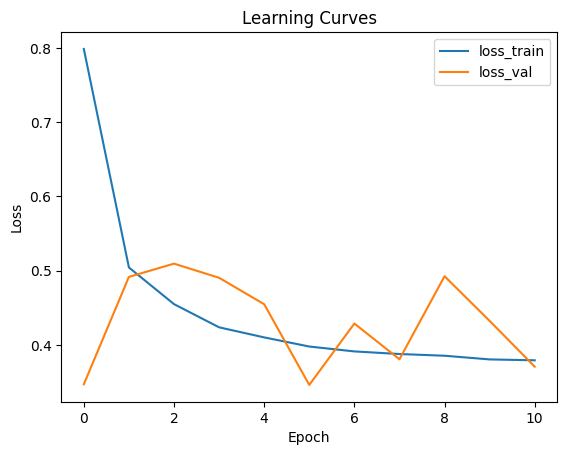

In [193]:
train_metrics = experiment_path / "train_metrics_.csv"
val_metrics = experiment_path / "metrics_.csv"

train_metrics_df = pd.read_csv(train_metrics)
val_metrics_df = pd.read_csv(val_metrics)

merged_df = pd.merge(train_metrics_df, val_metrics_df, on='epoch')
merged_df.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y"], inplace=True)


# Extract loss_x and loss_y from merged_df
loss_x = merged_df['loss_x']
loss_y = merged_df['loss_y']

# Plot learning curves
plt.plot(loss_x, label='loss_train')
plt.plot(loss_y, label='loss_val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Look at embeddings

In [194]:
embeddings = np.array(per_batch_test_loaded["embeddings"])[0]
first_embedding = embeddings[0]
first_embedding.shape

(1700, 256)

(1700, 2)


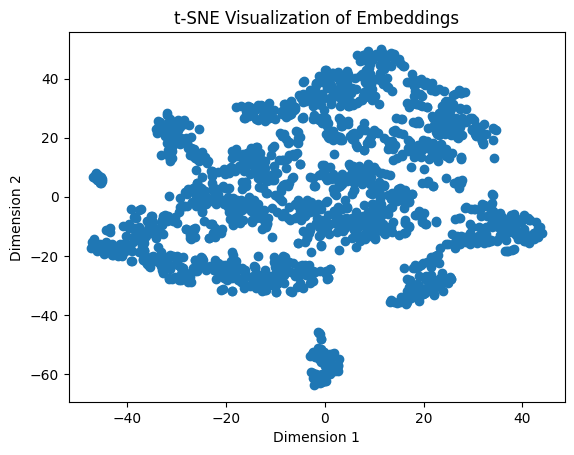

In [195]:
# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(first_embedding)
print(embeddings_tsne.shape)
# Plot the t-SNE visualization
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


In [205]:
from sklearn.cluster import KMeans

cluster_count = 8
# Assuming 'embeddings' is the variable containing the embedding data
# Perform k-means clustering with k=5 (you can change the value of k as per your requirement)
kmeans = KMeans(n_clusters=cluster_count)
kmeans.fit(embeddings_tsne)

# Get the predicted class labels for each data point
class_labels = kmeans.labels_

# Print the class labels
print(class_labels)

[0 9 3 ... 9 9 9]


/Users/oliver/miniconda3/envs/mvts/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


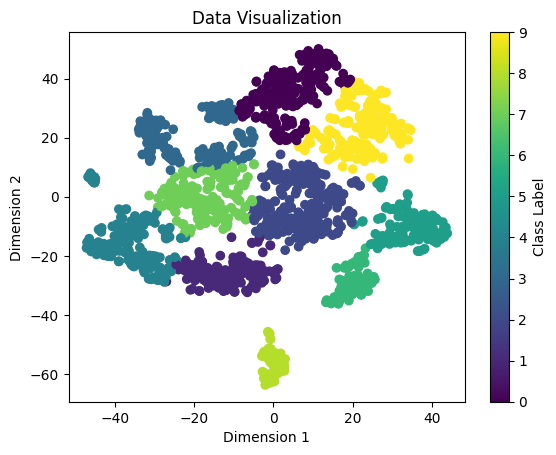

In [206]:
# Extract the data and class labels
data = embeddings_tsne
class_labels = class_labels

# Create a scatter plot
plt.scatter(data[:, 0], data[:, 1], c=class_labels, cmap='viridis')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Class Label')

# Add labels and title
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Data Visualization')

# Show the plot
plt.show()

In [207]:
true_data = np.array(per_batch_test_loaded["targets"])[0]
first_batch = true_data[0]
first_batch.shape

(1700, 428)

(1700, 2)


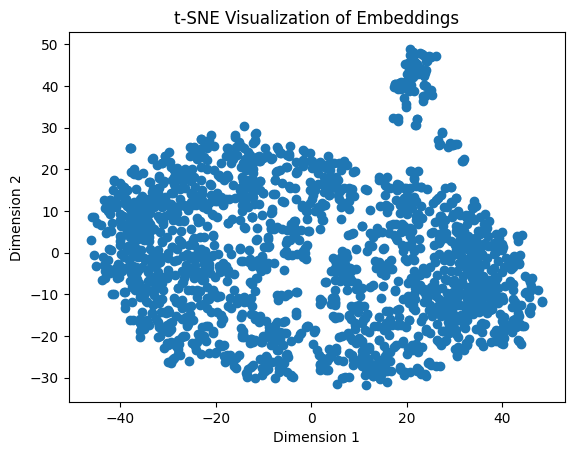

In [208]:
# Perform t-SNE on the true data
tsne = TSNE(n_components=2, random_state=42)
true_tsne = tsne.fit_transform(first_batch)
print(true_tsne.shape)
# Plot the t-SNE visualization
plt.scatter(true_tsne[:, 0], true_tsne[:, 1])
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


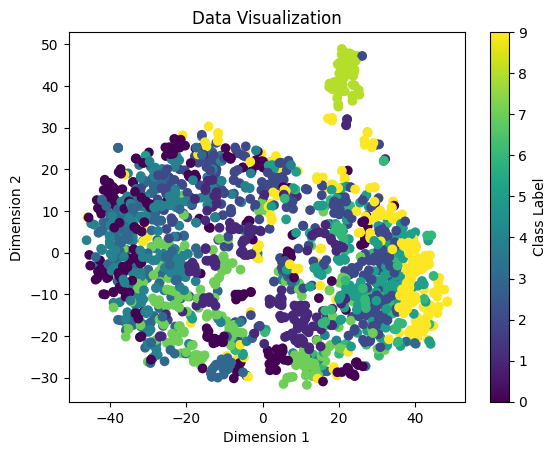

In [209]:
# Extract the data and class labels
data = true_tsne
class_labels = class_labels

# Create a scatter plot
plt.scatter(data[:, 0], data[:, 1], c=class_labels, cmap='viridis')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Class Label')

# Add labels and title
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Data Visualization')

# Show the plot
plt.show()

In [210]:
# Assuming 'embeddings' is the variable containing the embedding data
# Perform k-means clustering with k=5 (you can change the value of k as per your requirement)
kmeans = KMeans(n_clusters=cluster_count)
kmeans.fit(true_tsne)

# Get the predicted class labels for each data point
true_class_labels = kmeans.labels_

# Print the class labels
print(true_class_labels)

[5 3 5 ... 7 7 7]


/Users/oliver/miniconda3/envs/mvts/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


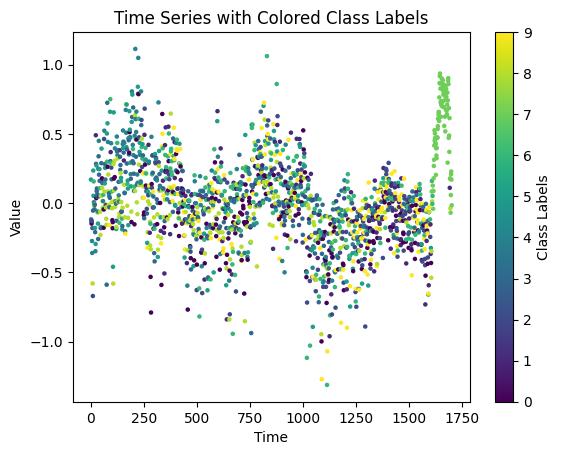

In [211]:
# Create a scatter plot
plt.scatter(list(range(first_batch.shape[0])), list(first_batch[: ,0]) , c=list(true_class_labels), s=5)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Colored Class Labels')

# Show the colorbar
cbar = plt.colorbar()
cbar.set_label('Class Labels')

# Display the plot
plt.show()

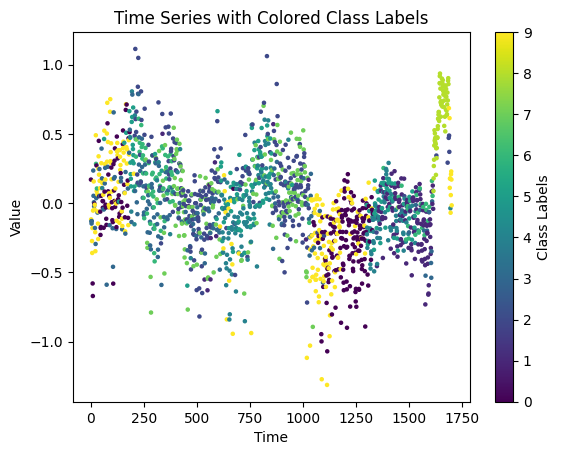

In [212]:
# Create a scatter plot
plt.scatter(list(range(first_batch.shape[0])), list(first_batch[: ,0]) , c=list(class_labels), s=5)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Colored Class Labels')

# Show the colorbar
cbar = plt.colorbar()
cbar.set_label('Class Labels')

# Display the plot
plt.show()

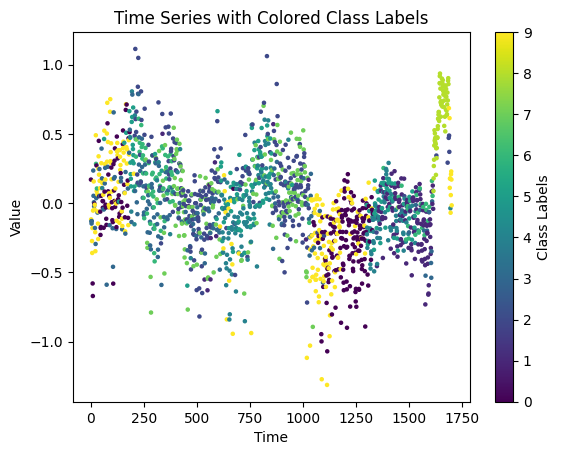

In [213]:
# Create a scatter plot
plt.scatter(list(range(first_batch.shape[0])), list(first_batch[: ,0]) , c=list(class_labels), s=5)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Colored Class Labels')

# Show the colorbar
cbar = plt.colorbar()
cbar.set_label('Class Labels')

# Display the plot
plt.show()